<a href="https://colab.research.google.com/github/nitaymayo/My_Portfolio/blob/main/AI/Tensorflow/Project_Number_2_SkimLit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SKIMLIT Project

A model that gets an abstract medical text as an input and outputs each sentences main idea<br>
makes it easier to read through the abstracts :)

The main purpose of this code is to build an NLP model that can help reaserchers read medical documents

In [ ]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
! wget https://raw.githubusercontent.com/nitaymayo/my_repo/main/helper_functions.py

from helper_functions import *

--2023-01-25 16:47:15--  https://raw.githubusercontent.com/nitaymayo/my_repo/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10804 (11K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.55K  --.-KB/s    in 0s      

2023-01-25 16:47:15 (88.7 MB/s) - ‘helper_functions.py’ saved [10804/10804]



## Confirm access to a GPU

In [ ]:
!nvidia-smi

Wed Jan 25 16:47:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get the Data

this model is a replica of PubMed 200k, so is trained on the same data

In [ ]:
! git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 6.87 MiB/s, done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# Check the data files on the 20K dataset
!ls /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [ ]:
!head /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt

###24293578
OBJECTIVE	To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .
METHODS	A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .
METHODS	Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .
METHODS	Pain was assessed using the visual analog pain scale ( @-@ mm ) .
METHODS	Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .
METHODS	Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP 

### load the 20k data set

In [ ]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
import os
filenames = [data_dir + name for name in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [ ]:
# Tensorboard logs dir
SAVE_DIR = "models_logs"

### Preprocessing the data

In [ ]:
def get_lines(filename):
  """
  Reads a text filename and returns the lines of the text as a list.

  Args:
    filename: a String constaning the file location

  Returns:
    List: of the lines in the file
  """

  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
train_data = get_lines(filenames[0])
train_data[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
def process_lines_to_list(filename):
  """
  Returns a list of dictioneries of abstract line data

  Args:
    filename: String, the name of the text file to read 

  Returns:
    List of dictioneries with the number of the line, the text of the line, the target label and the total number of lines.
  """

  input_lines = get_lines(filename)

  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1

        abstract_samples.append(line_data)
    else:
      abstract_lines += line

    
  
  return abstract_samples


In [ ]:
%%time
train_samples = process_lines_to_list(data_dir + "/train.txt")
val_samples = process_lines_to_list(data_dir + "/dev.txt")
test_samples = process_lines_to_list(data_dir + "/test.txt")

CPU times: user 415 ms, sys: 97.1 ms, total: 512 ms
Wall time: 514 ms


### Further visualiztion

In [ ]:
import pandas as pd

In [ ]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
# cheking for label balance
train_df["target"].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

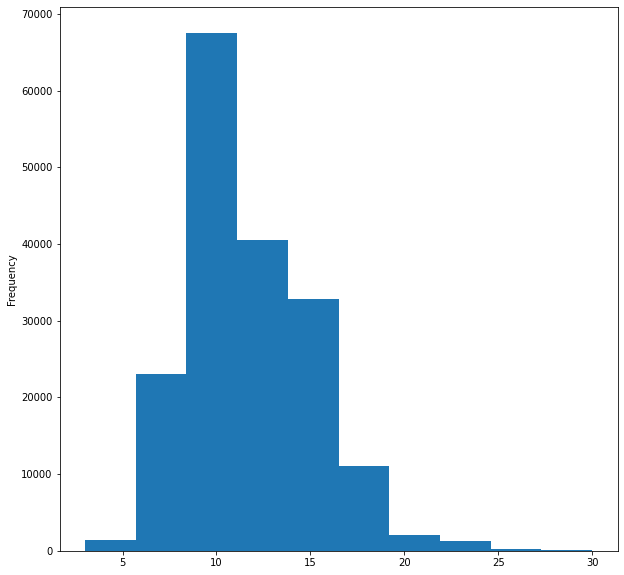

In [ ]:
train_df["total_lines"].plot.hist(figsize=(10,10))

In [ ]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

### Handeling the labels

In [ ]:
#One hot encoding

from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))

In [ ]:
train_labels_one_hot[:5], train_labels_one_hot.shape

(array([[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]]), (180040, 5))

In [ ]:
#Label encoding

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_labels = label_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
test_labels = label_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))
val_labels = label_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
train_labels[:5], train_labels.shape

(array([3, 2, 2, 2, 2]), (180040,))

In [ ]:
# Get the names and numbers of the classes
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
class_names, num_classes

(array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object), 5)

# Creating the models

The 5 model:
0. Base Model: naive bayes model
1. Conv1D with token embedding
2. TF Hub Pretrained Feature Extractor
3. Conv1D with character embeddings
4. Pretrained token embeddings + character embeddings
5. Pretrained token embeddings + character embeddings + positional embeddings

## Creating a Text Vectorizer and embedding layer

In [ ]:
# undestanding the average word count in a sentence to abjust the vectorizer to the data
sentences_length = [len(sent.split()) for sent in train_sentences]
avg_sentences_len = np.mean(sentences_length)
sentences_length[:5], avg_sentences_len

([49, 27, 15, 14, 35], 26.338269273494777)

(array([1.6499e+04, 5.6664e+04, 5.2683e+04, 2.9050e+04, 1.3111e+04,
        5.6610e+03, 3.0490e+03, 1.5190e+03, 8.0800e+02, 4.3200e+02,
        2.2600e+02, 1.2800e+02, 7.7000e+01, 3.9000e+01, 3.0000e+01,
        1.5000e+01, 9.0000e+00, 8.0000e+00, 4.0000e+00, 8.0000e+00,
        7.0000e+00, 5.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1.        ,  10.83333333,  20.66666667,  30.5       ,
         40.33333333,  50.16666667,  60.        ,  69.83333333,
         79.66666667,  89.5       ,  99.33333333, 109.16666667,
        119.        , 128.83333333, 138.66666667, 148.5       ,
        158.33333333, 168.16666667, 178.        , 187.83333333,
        197.66666667, 207.5       , 217.33333333, 227.16666667,
        237.        , 246.83333333, 256.66666667, 266.5       ,
        276.33333333, 286.16666667, 296.        ]),
 <a list of 30 Patch objects>)

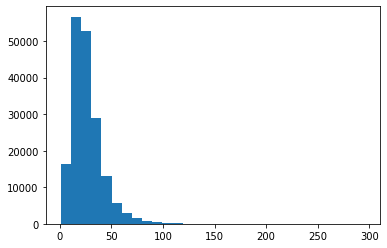

In [ ]:
plt.hist(sentences_length, bins=30)

In [ ]:
# Understanig the best length for the tet vectorizer
best_vectorizer_length = int(np.percentile(sentences_length, 95))

In [ ]:
from tensorflow.keras.layers import TextVectorization

In [ ]:
# creating the text vectorizer

max_tokens = 68_000
max_length = best_vectorizer_length

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_mode='int',
                                    output_sequence_length=max_length)

In [ ]:
# Let the vectorizer learn from the train set
text_vectorizer.adapt(train_sentences)

In [ ]:
# testing the vectorizer
sample_sentence = "There is a dog on the table"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 55), dtype=int64, numpy=
array([[  61,   20,    8, 6412,   18,    2, 3551,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])>

In [ ]:
# Understanding the vectorizer preformance
vocab = text_vectorizer.get_vocabulary()
vocab[:9], vocab[-5:], len(vocab)

(['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a'],
 ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp'],
 64841)

### Creating the embbeding layer

In [ ]:
from tensorflow.keras.layers import Embedding

In [ ]:
embedding_layer = Embedding(len(vocab),
                            output_dim=128,
                            input_length=max_length,
                            mask_zero=True)

In [ ]:
# testing the embedding layer
import random
sample = random.choice(train_sentences)

print("Original:\n", sample)
print("_________")
print("Vectiruzed:\n", text_vectorizer(sample))
print("Embedded:\n", embedding_layer(text_vectorizer(sample)))

Original:
 in over-weight patients with t@d , m+s may have a beneficial effect on adiposity with relation to these different effects on two incretins .
_________
Vectiruzed:
 tf.Tensor(
[    5  1065    12     7  1990   893    91    99     8   748    70    18
  4844     7  1852     6   111   197    71    18    51 20414     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0], shape=(55,), dtype=int64)
Embedded:
 tf.Tensor(
[[ 0.02449733  0.04961291 -0.03666217 ... -0.00063946  0.01726438
  -0.03500495]
 [-0.04633205  0.00773351 -0.00764654 ...  0.01635176 -0.01599346
   0.00511159]
 [-0.04015332 -0.01557661 -0.02652172 ...  0.0495174  -0.03859161
   0.0184846 ]
 ...
 [ 0.04511198  0.04554809  0.04850877 ... -0.03513556 -0.00609376
   0.0433133 ]
 [ 0.04511198  0.04554809  0.04850877 ... -0.03513556 -0.00609376
   0.0433133 ]
 [ 0.04511198  0.04

## Creating datasets(Improving models preforamnce)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

##Model 0: Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

In [ ]:
# build a sklearn pipeline
model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

In [ ]:
# train the baseline
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# evaluating the model
model_0_score = model_0.score(val_sentences, val_labels)
model_0_score

0.7218323844829869

In [ ]:
base_line_preds = model_0.predict(val_sentences)
base_line_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
base_line_results = evaluation_dictonary(val_labels, base_line_preds)
base_line_results

{'accuracy': 0.7218323844829869,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1_score': 0.6989250353450294}

## Model 1: Conv1D

In [ ]:
from tensorflow.keras import layers

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)

x = text_vectorizer(inputs)
x = embedding_layer(x)
x = layers.Conv1D(128, kernel_size=5, padding="same", activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)

outputs = layers.Dense(len(class_names), activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 55, 128)           8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 128)           82048     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 645   

In [ ]:
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps=int(0.1*len(val_dataset)),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "model_1_Conv1D")])

Saving TensorBoard log files to: models_logs/model_1_Conv1D/20230125-164816
Epoch 1/3
562/562 [==============================] - 15s 12ms/step - loss: 0.8829 - accuracy: 0.6519 - val_loss: 0.6765 - val_accuracy: 0.7414
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.6531 - accuracy: 0.7610 - val_loss: 0.6281 - val_accuracy: 0.7766
Epoch 3/3
562/562 [==============================] - 9s 16ms/step - loss: 0.6116 - accuracy: 0.7783 - val_loss: 0.5884 - val_accuracy: 0.7852


In [ ]:
model_1.evaluate(val_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.5892 - accuracy: 0.7893


[0.5892345309257507, 0.7893221378326416]

In [ ]:
model_1_preds = model_1.predict(val_dataset)
model_1_preds[:5]

945/945 [==============================] - 2s 2ms/step


array([[4.8459283e-01, 1.5191451e-01, 7.1190625e-02, 2.6342398e-01,
        2.8878085e-02],
       [3.9178020e-01, 3.3064210e-01, 1.7113270e-02, 2.4923450e-01,
        1.1229967e-02],
       [1.1014237e-01, 4.7007273e-03, 1.3413680e-03, 8.8379461e-01,
        2.0834519e-05],
       [2.1254913e-05, 4.8595178e-04, 9.7779226e-01, 1.0119868e-05,
        2.1690408e-02],
       [1.2397963e-03, 3.4966111e-02, 3.3045298e-01, 5.1417097e-04,
        6.3282698e-01]], dtype=float32)

In [ ]:
model_1_preds = tf.argmax(model_1_preds, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# understandig the model preformance
model_1_results = evaluation_dictonary(val_labels, model_1_preds)
model_1_results

{'accuracy': 0.7893221236594731,
 'precision': 0.7861669735731754,
 'recall': 0.7893221236594731,
 'f1_score': 0.7869365408416018}

In [ ]:
base_line_results

{'accuracy': 0.7218323844829869,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1_score': 0.6989250353450294}

## Model 2: Pretrained Embedding layer

Using the USE from tensorflow hub

In [ ]:
import tensorflow_hub as hub

embedding_layer_pretrained = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                            trainable=False,
                                            name="USE")

In [ ]:
# Testing the Pretrained Embedding layer
random_sentence = random.choice(train_sentences)

print("Original\n", random_sentence)
print("--------")
embedded_sentence = embedding_layer_pretrained([random_sentence])
print("Embedded\n", embedded_sentence[0][:25])
print("Embedding length: ", len(embedded_sentence[0]))

Original
 based on the pharmacokinetics model , the recommended @,@ mg/day of abiraterone acetate resulted in similar abiraterone exposure for patients with mcrpc regardless of prior chemotherapy .
--------
Embedded
 tf.Tensor(
[-0.05315891  0.06964157 -0.02922054 -0.0545826  -0.02759862 -0.02787057
  0.06050581 -0.00242276  0.02874031  0.07467051  0.08933553  0.01126078
 -0.01433641  0.08104023  0.03027172 -0.02329199 -0.09455799 -0.04296355
 -0.06935357  0.01184764 -0.00946753 -0.00322672 -0.04478989  0.02650814
  0.06064074], shape=(25,), dtype=float32)
Embedding length:  512


In [ ]:
from tensorflow.keras import layers

inputs = layers.Input(shape=[], dtype=tf.string)

x = embedding_layer_pretrained(inputs)
x = layers.Dense(128, activation="relu")(x)

outputs = layers.Dense(len(class_names), activation="softmax")(x)

model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss="categorical_crossentropy",
                optimizer='Adam',
                metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_2_history = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=val_dataset,
                              validation_steps=int(0.1*len(val_dataset)),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                    "model_2_Pretrained_Embedding")])

Saving TensorBoard log files to: models_logs/model_2_Pretrained_Embedding/20230125-165001
Epoch 1/3
562/562 [==============================] - 11s 14ms/step - loss: 0.9160 - accuracy: 0.6519 - val_loss: 0.7939 - val_accuracy: 0.6925
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7661 - accuracy: 0.7037 - val_loss: 0.7521 - val_accuracy: 0.7045
Epoch 3/3
562/562 [==============================] - 8s 15ms/step - loss: 0.7482 - accuracy: 0.7150 - val_loss: 0.7345 - val_accuracy: 0.7164


In [ ]:
# Evaluate on the whole validation dataset\
model_2.evaluate(val_dataset)

945/945 [==============================] - 12s 13ms/step - loss: 0.7372 - accuracy: 0.7147


[0.7372194528579712, 0.714682936668396]

In [ ]:
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs

945/945 [==============================] - 11s 12ms/step


array([[4.3881422e-01, 3.6140299e-01, 2.3684287e-03, 1.8708676e-01,
        1.0327653e-02],
       [3.6933324e-01, 4.8552734e-01, 3.9342265e-03, 1.3797286e-01,
        3.2323818e-03],
       [2.2023444e-01, 1.2386648e-01, 1.5568768e-02, 5.9902573e-01,
        4.1304559e-02],
       ...,
       [1.8473632e-03, 5.0034933e-03, 4.5940392e-02, 7.5103482e-04,
        9.4645768e-01],
       [5.2403905e-03, 4.8742972e-02, 1.9416009e-01, 1.8159585e-03,
        7.5004053e-01],
       [1.9164474e-01, 2.2624366e-01, 5.1654446e-01, 1.2082762e-02,
        5.3484317e-02]], dtype=float32)

In [ ]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
model_2_results = evaluation_dictonary(val_labels, model_2_preds)
model_2_results

{'accuracy': 0.7146829074539918,
 'precision': 0.7147019738369456,
 'recall': 0.7146829074539918,
 'f1_score': 0.7119461178708154}

In [ ]:
base_line_results

{'accuracy': 0.7218323844829869,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1_score': 0.6989250353450294}

## Model 3: Conv1D with Character embeddings

In [ ]:
# Make function to split sentences to chars

def split_to_chars(text):
  return " ".join(list(text))

split_to_chars("Hello World, i am mr robot")

'H e l l o   W o r l d ,   i   a m   m r   r o b o t'

In [ ]:
#splitting the datasets
train_chars = [split_to_chars(sentence) for sentence in train_sentences]
val_chars = [split_to_chars(sentence) for sentence in val_sentences]
test_chars = [split_to_chars(sentence) for sentence in test_sentences]

val_chars[:5]

['i g e   s e n s i t i z a t i o n   t o   a s p e r g i l l u s   f u m i g a t u s   a n d   a   p o s i t i v e   s p u t u m   f u n g a l   c u l t u r e   r e s u l t   a r e   c o m m o n   i n   p a t i e n t s   w i t h   r e f r a c t o r y   a s t h m a   .',
 'i t   i s   n o t   c l e a r   w h e t h e r   t h e s e   p a t i e n t s   w o u l d   b e n e f i t   f r o m   a n t i f u n g a l   t r e a t m e n t   .',
 'w e   s o u g h t   t o   d e t e r m i n e   w h e t h e r   a   @ - m o n t h   c o u r s e   o f   v o r i c o n a z o l e   i m p r o v e d   a s t h m a - r e l a t e d   o u t c o m e s   i n   p a t i e n t s   w i t h   a s t h m a   w h o   a r e   i g e   s e n s i t i z e d   t o   a   f u m i g a t u s   .',
 'a s t h m a t i c   p a t i e n t s   w h o   w e r e   i g e   s e n s i t i z e d   t o   a   f u m i g a t u s   w i t h   a   h i s t o r y   o f   a t   l e a s t   @   s e v e r e   e x a c e r b a t i o n s   i n   t h e   p r e v 

In [ ]:
char_length = [len(sentence) for sentence in train_sentences]
avg_char_length = np.mean(char_length)
avg_char_length

149.3662574983337

(array([9.2691e+04, 7.6343e+04, 9.6890e+03, 1.0890e+03, 1.6700e+02,
        4.2000e+01, 1.3000e+01, 3.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([1.0000e+00, 1.3950e+02, 2.7800e+02, 4.1650e+02, 5.5500e+02,
        6.9350e+02, 8.3200e+02, 9.7050e+02, 1.1090e+03, 1.2475e+03,
        1.3860e+03]),
 <a list of 10 Patch objects>)

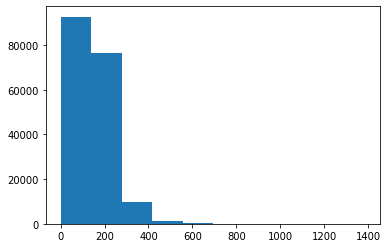

In [ ]:
# Check the distribution of the char_length
plt.hist(char_length, bins=10)

In [ ]:
# Find the best length for the vectorizer

output_char_length = int(np.percentile(char_length, 95))
output_char_length

290

In [ ]:
# Getting all the possible characters
import string

all_charcters = string.ascii_lowercase + string.digits + string.punctuation

all_charcters

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

### Creating char-level text vectorizer

In [ ]:
num_tokens = len(all_charcters)

char_vectorizer = TextVectorization(max_tokens=num_tokens,
                                    output_sequence_length=output_char_length,
                                    name="char-level-vectorizer")

In [ ]:
# Adapt the vectorizer
char_vectorizer.adapt(train_chars)


In [ ]:
# Understandig the vocab of the vectorizer
char_vocab = char_vectorizer.get_vocabulary()
print(f"Num of Different words: {len(char_vocab)}")
print(f"5 most common: {char_vocab[:5]}")
print(f"5 least common: {char_vocab[-5:]}")

Num of Different words: 28
5 most common: ['', '[UNK]', 'e', 't', 'i']
5 least common: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test the vectorizer

random_train_chars = random.choice(train_chars)

print(f"Text:\n{random_train_chars}\nLength: {len(random_train_chars.split())}")
print(f"________\n vectorized chars:\n{char_vectorizer([random_train_chars])}\n\n Length: {len(char_vectorizer([random_train_chars])[0])}")


Text:
t h e   i n t e r v e n t i o n   r e d u c e d   t h e   p r o p o r t i o n   o f   v i s i t s   w i t h   b v   c o m p a r e d   t o   p l a c e b o   (   @   %   v s   @   %   ;   r e l a t i v e   r i s k   - l s b -   r r   - r s b -   @   ,   @   %   c o n f i d e n c e   i n t e r v a l   - l s b -   c i   - r s b -   @   - @   )   .
Length: 137
________
 vectorized chars:
[[ 3 13  2  4  6  3  2  8 21  2  6  3  4  7  6  8  2 10 16 11  2 10  3 13
   2 14  8  7 14  7  8  3  4  7  6  7 17 21  4  9  4  3  9 20  4  3 13 22
  21 11  7 15 14  5  8  2 10  3  7 14 12  5 11  2 22  7 21  9  8  2 12  5
   3  4 21  2  8  4  9 23 12  9 22  8  8  8  9 22 11  7  6 17  4 10  2  6
  11  2  4  6  3  2  8 21  5 12 12  9 22 11  4  8  9 22  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0

### Creating char level embedding layer

In [ ]:
from tensorflow.keras.layers import Embedding

char_embedding = Embedding(input_dim=len(char_vocab),
                           output_dim=25,
                           mask_zero=True,
                           input_length=output_char_length)

In [ ]:
# Test the embedding layer

random_train_chars = random.choice(train_chars)

print(f"Text:\n{random_train_chars}\nLength: {len(random_train_chars.split())}")
print(f"________\n vectorized chars:\n{char_vectorizer([random_train_chars])}\n\n Length: {len(char_vectorizer([random_train_chars])[0])}")
print(f"________\n Embedded chars: {char_embedding(char_vectorizer([random_train_chars]))}\n\n shape: {char_embedding(char_vectorizer([random_train_chars])).shape}")

Text:
o u r   f i n d i n g s   m a y   h e l p   e x p l a i n   t h e   e f f i c a c y   o f   n t x   t o   r e d u c e   h e a v y   d r i n k i n g   ,   b u t   n o t   t o   m a i n t a i n   a b s t i n e n c e   .
Length: 90
________
 vectorized chars:
[[ 7 16  8 17  4  6 10  4  6 18  9 15  5 19 13  2 12 14  2 24 14 12  5  4
   6  3 13  2  2 17 17  4 11  5 11 19  7 17  6  3 24  3  7  8  2 10 16 11
   2 13  2  5 21 19 10  8  4  6 23  4  6 18 22 16  3  6  7  3  3  7 15  5
   4  6  3  5  4  6  5 22  9  3  4  6  2  6 11  2  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

### Building the model:

In [ ]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)

x = char_vectorizer(inputs)
x = char_embedding(x)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)

outputs = layers.Dense(len(class_names), activation="softmax")(x)

model_3 = tf.keras.Model(inputs, outputs, name="model_3")

model_3.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

In [ ]:
model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char-level-vectorizer (Text  (None, 290)              0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5)                 325 

In [ ]:
# Creating dataset of chars data for better preformance

train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model

model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "model_3_char_embedding_with_maxPool")])

Saving TensorBoard log files to: models_logs/model_3_char_embedding_with_maxPool/20230125-165116
Epoch 1/3
562/562 [==============================] - 4s 6ms/step - loss: 1.2539 - accuracy: 0.4914 - val_loss: 1.0514 - val_accuracy: 0.5861
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.0154 - accuracy: 0.5935 - val_loss: 0.9572 - val_accuracy: 0.6193
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9328 - accuracy: 0.6345 - val_loss: 0.8824 - val_accuracy: 0.6616


In [ ]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_prebs = tf.argmax(model_3_pred_probs, axis=1)
model_3_prebs

945/945 [==============================] - 2s 3ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 2, ..., 4, 4, 1])>

In [ ]:
model_3_results = evaluation_dictonary(val_labels, model_3_prebs)
model_3_results

{'accuracy': 0.6509665033761419,
 'precision': 0.6398861523255913,
 'recall': 0.6509665033761419,
 'f1_score': 0.6384685945437741}

In [ ]:
base_line_results

{'accuracy': 0.7218323844829869,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1_score': 0.6989250353450294}

## Model 4: char embedding + token embedding

In [ ]:
#Creating a token inputs model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embedding = embedding_layer_pretrained(token_inputs)
token_outputs = layers.Dense(128, activation="relu", name="token_output")(token_embedding)
token_model = tf.keras.Model(token_inputs, token_outputs, name="token_model")

#Creating char inputs model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vector = char_vectorizer(char_inputs)
char_embed_layer = char_embedding(char_vector)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embed_layer)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# Concatonating the 2 outputs
token_char_concat = layers.Concatenate()([token_model.output,
                                          char_model.output])

# Creating the model output layer
combained_dropout = layers.Dropout(0.5)(token_char_concat)
combained_dense = layers.Dense(128, activation="relu")(combained_dropout)
final_dropout = layers.Dropout(0.5)(combained_dense)
outputs = layers.Dense(len(class_names), activation="softmax")(final_dropout)

# Creating the whole model
model_4 = tf.keras.Model([token_inputs, char_inputs], outputs)


In [ ]:
model_4.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char-level-vectorizer (TextVec  (None, 290)         0           ['char_input[0][0]']             
 torization)                                                                                      
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   ['token_input[0][0]']      

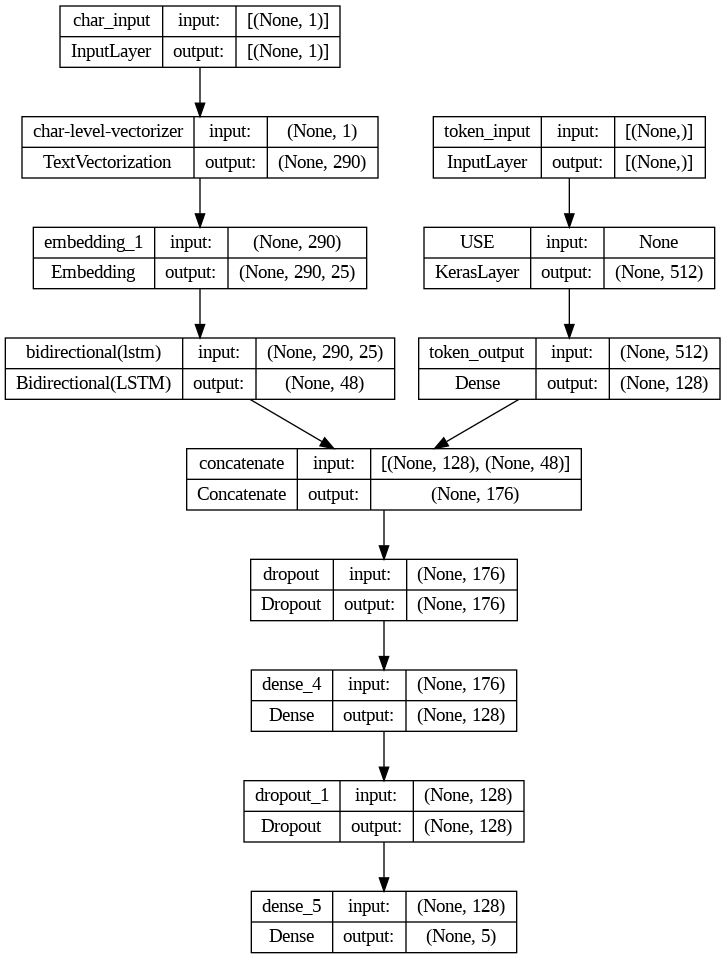

In [ ]:
# Plot the model 4
from keras.utils import plot_model

plot_model(model_4, show_shapes=True)

In [ ]:
# Compile the model
model_4.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

In [ ]:
# Function to prepare the datasets

def prepare_char_token_dataset(token_input, char_input, labels):

  char_token_data = tf.data.Dataset.from_tensor_slices((token_input, char_input))
  char_token_labels = tf.data.Dataset.from_tensor_slices(labels)

  return tf.data.Dataset.zip((char_token_data, char_token_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Creating the datasets

train_char_token_dataset = prepare_char_token_dataset(train_sentences, train_chars, train_labels_one_hot)
val_char_token_dataset = prepare_char_token_dataset(val_sentences, val_chars, val_labels_one_hot)
test_char_token_dataset = prepare_char_token_dataset(test_sentences, test_chars, test_labels_one_hot)

train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Trainning the model

model_4_history = model_4.fit(train_char_token_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1*len(val_char_token_dataset)),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_4_combained_char_token")])

Saving TensorBoard log files to: models_logs/model_4_combained_char_token/20230125-165134
Epoch 1/3
562/562 [==============================] - 39s 55ms/step - loss: 0.9810 - accuracy: 0.6103 - val_loss: 0.7848 - val_accuracy: 0.6965
Epoch 2/3
562/562 [==============================] - 29s 52ms/step - loss: 0.8056 - accuracy: 0.6926 - val_loss: 0.7189 - val_accuracy: 0.7237
Epoch 3/3
562/562 [==============================] - 26s 47ms/step - loss: 0.7792 - accuracy: 0.7033 - val_loss: 0.6953 - val_accuracy: 0.7380


In [ ]:
model_4_preds = tf.argmax(model_4.predict(val_char_token_dataset), axis=1)
model_4_preds[:5]

945/945 [==============================] - 24s 22ms/step


<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 1, 3, 2, 2])>

In [ ]:
model_4_results = evaluation_dictonary(val_labels, model_4_preds)
model_4_results

{'accuracy': 0.7339798755461406,
 'precision': 0.7330721271516287,
 'recall': 0.7339798755461406,
 'f1_score': 0.7306537493121097}

In [ ]:
base_line_results

{'accuracy': 0.7218323844829869,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1_score': 0.6989250353450294}

## Model 5: adding the posittional embedding

same as model 4 but with posittional embedding

In [ ]:
# Creating one hot encoding to the sentences line number
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

(array([7.4992e+04, 5.7332e+04, 3.5767e+04, 1.0787e+04, 1.0110e+03,
        1.3500e+02, 1.6000e+01]),
 array([ 0.        ,  4.28571429,  8.57142857, 12.85714286, 17.14285714,
        21.42857143, 25.71428571, 30.        ]),
 <a list of 7 Patch objects>)

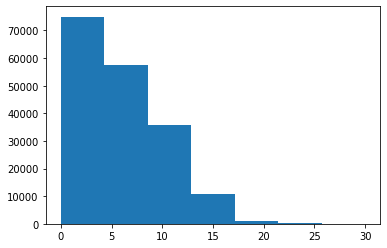

In [ ]:
plt.hist(train_df["line_number"], bins=7)

In [ ]:
np.percentile(train_df["line_number"], 95)

13.0

In [ ]:
# Creating the one hot encoding, 15 as the one hot vector length due to the 95 percentile output
train_line_number_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_number_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_number_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

train_line_number_one_hot[:10]

<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [ ]:
# Doing the same for total_lines
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

(array([ 4746., 62788., 79629., 26743.,  5290.,   727.,   117.]),
 array([ 3.        ,  6.85714286, 10.71428571, 14.57142857, 18.42857143,
        22.28571429, 26.14285714, 30.        ]),
 <a list of 7 Patch objects>)

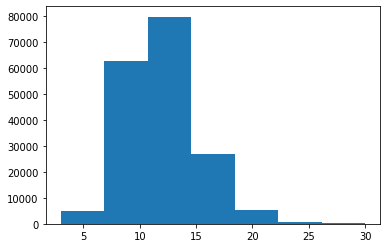

In [ ]:
plt.hist(train_df["total_lines"], bins=7)

In [ ]:
np.percentile(train_df["total_lines"], 95)

18.0

In [ ]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=18)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=18)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=18)

train_total_lines_one_hot[:5]

<tf.Tensor: shape=(5, 18), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0.]], dtype=float32)>

### Building the model

steps:
1. Create token-level model
2. Create char-level model
3. Create model for "line_number" 
4. Create model for "total_lines"
5. Concatenating the outputs of the token and the char models
6. Concatenating the output of the 1 and 2 models with the line_number and total_lines model
7. Create an output of all the models to a probability vector
8. Creating a model with the inputs and outputs

In [ ]:
from tensorflow.keras import layers

# Step 1
token_input = layers.Input(shape=[], dtype=tf.string, name="Token_Input")
token_embedding = embedding_layer_pretrained(token_input)
token_output = layers.Dense(128, activation="relu")(token_embedding)
token_model = tf.keras.Model(token_input, token_output)

# Step 2
char_input = layers.Input(shape=(1,), dtype=tf.string, name="Char_Input")
char_vector = char_vectorizer(char_input)
char_embed = char_embedding(char_vector)
char_output = layers.Bidirectional(layers.LSTM(24))(char_embed)
char_model = tf.keras.Model(char_input, char_output)

# Step 3
line_number_input = layers.Input(shape=(15), name="line_number_input")
line_number_x = layers.Dense(32, activation="relu")(line_number_input)
line_number_dropout = layers.Dropout(0.5)(line_number_x)
line_number_output = layers.Dense(32, activation="relu")(line_number_dropout)
line_number_model = tf.keras.Model(line_number_input, line_number_output)

# Step 4
total_lines_input = layers.Input(shape=(18), name="total_lines_input")
total_lines_x = layers.Dense(32, activation="relu")(total_lines_input)
total_lines_dropout = layers.Dropout(0.5)(total_lines_x)
total_lines_output = layers.Dense(32, activation="relu")(total_lines_dropout)
total_lines_model = tf.keras.Model(total_lines_input, total_lines_output)

# Step 5
token_char_concat = layers.Concatenate(name="token_char_concat")([char_model.output,
                                        token_model.output])
token_char_dense = layers.Dense(256, activation="relu")(token_char_concat)
token_char_dropout = layers.Dropout(0.5)(token_char_dense)

# Step 6
all_inputs_concat = layers.Concatenate(name="all_inputs_concat")([token_char_dropout,
                                      line_number_model.output,
                                      total_lines_model.output])

# Step 7
final_output = layers.Dense(len(class_names), activation="softmax", name="Final_Output")(all_inputs_concat)

# Step 8
model_5 = tf.keras.Model([token_input, char_input, line_number_input, total_lines_input], final_output)

In [ ]:
model_5.summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Char_Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 char-level-vectorizer (TextVec  (None, 290)         0           ['Char_Input[0][0]']             
 torization)                                                                                      
                                                                                                  
 Token_Input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 290, 25)      700         ['char-level-vectorizer[7]

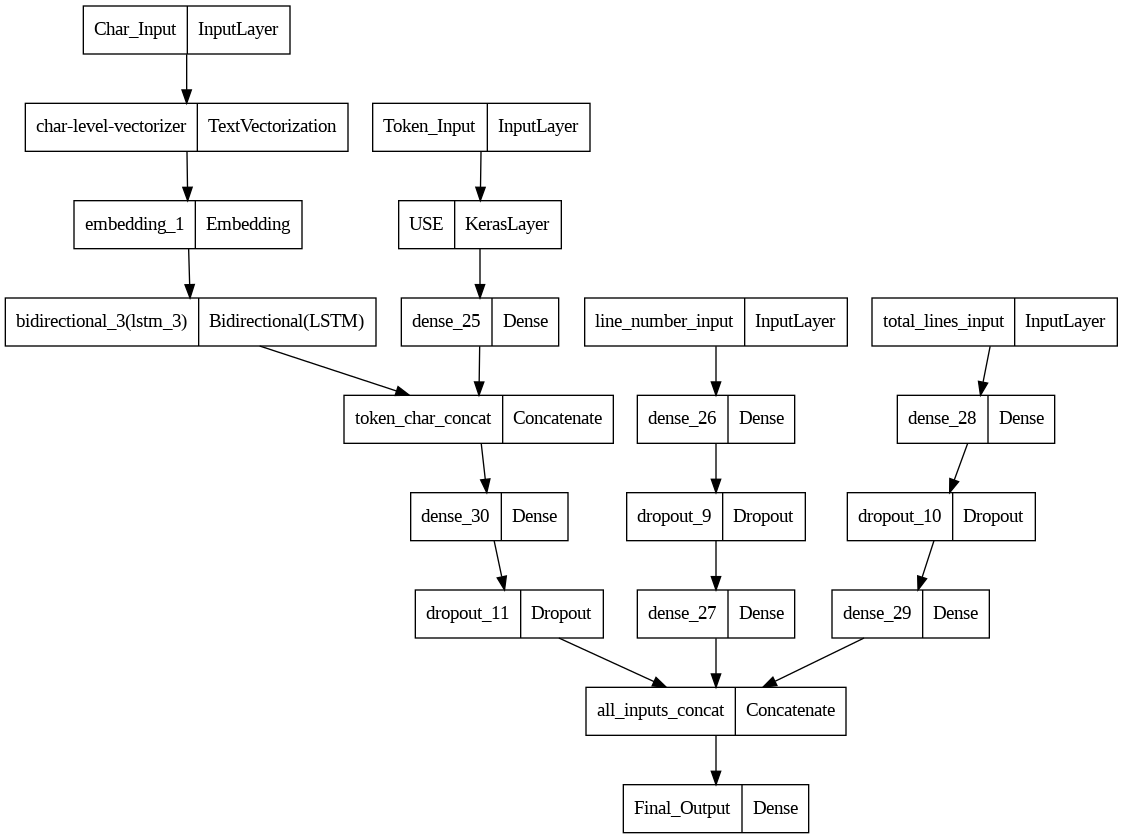

In [ ]:
from keras.utils import plot_model
plot_model(model_5)

In [ ]:
# Compile the model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer="Adam",
                metrics=["accuracy"])

In [ ]:
### Creating data pipelines for the multiinput

def create_tribrid_datasets(tokens, chars, line_numbers, total_lines, labels_one_hot):

  data = tf.data.Dataset.from_tensor_slices((tokens, chars, line_numbers, total_lines))
  labels = tf.data.Dataset.from_tensor_slices((labels_one_hot))
  dataset = tf.data.Dataset.zip((data, labels)).batch(32).prefetch(tf.data.AUTOTUNE)
  return dataset

In [ ]:
train_tribrid_dataset = create_tribrid_datasets(train_sentences, train_chars, train_line_number_one_hot, train_total_lines_one_hot, train_labels_one_hot)
val_tribrid_dataset = create_tribrid_datasets(val_sentences, val_chars, val_line_number_one_hot, val_total_lines_one_hot, val_labels_one_hot)
test_tribrid_dataset = create_tribrid_datasets(test_sentences, test_chars, test_line_number_one_hot, test_total_lines_one_hot, test_labels_one_hot)

train_tribrid_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fitting the model

model_5_history = model_5.fit(train_tribrid_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_tribrid_dataset)),
                              validation_data=val_tribrid_dataset,
                              validation_steps=int(0.1*len(val_tribrid_dataset)),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_5_tribrid_input")])

Saving TensorBoard log files to: models_logs/model_5_tribrid_input/20230125-172654
Epoch 1/3
562/562 [==============================] - 55s 84ms/step - loss: 1.1090 - accuracy: 0.7146 - val_loss: 0.9851 - val_accuracy: 0.8005
Epoch 2/3
562/562 [==============================] - 40s 72ms/step - loss: 0.9910 - accuracy: 0.8028 - val_loss: 0.9556 - val_accuracy: 0.8255
Epoch 3/3
562/562 [==============================] - 32s 57ms/step - loss: 0.9717 - accuracy: 0.8104 - val_loss: 0.9407 - val_accuracy: 0.8334


In [ ]:
model_5_preds = tf.argmax(model_5.predict(val_tribrid_dataset), axis=1)
model_5_preds[:5]

945/945 [==============================] - 22s 24ms/step


<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 3, 2, 2])>

In [ ]:
model_5_results = evaluation_dictonary(val_labels, model_5_preds)
model_5_results

{'accuracy': 0.8317555938037866,
 'precision': 0.8308030958285513,
 'recall': 0.8317555938037866,
 'f1_score': 0.8308213678461481}

In [ ]:
base_line_results

{'accuracy': 0.7218323844829869,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1_score': 0.6989250353450294}

# Comparing all models results

In [ ]:
all_model_results = pd.DataFrame({"model_0_baseline": base_line_results,
                                  "model_1_custom_token_embed": model_1_results,
                                  "model_2_pretraind_token_embed":model_2_results,
                                  "model_3_custom_char_embed": model_3_results,
                                  "model_4_token_char_embed": model_4_results,
                                  "model_5_token_char_pos_embed": model_5_results}).transpose()
all_model_results

,accuracy,precision,recall,f1_score
model_0_baseline,0.721832,0.718647,0.721832,0.698925
model_1_custom_token_embed,0.789322,0.786167,0.789322,0.786937
model_2_pretraind_token_embed,0.714683,0.714702,0.714683,0.711946
model_3_custom_char_embed,0.650967,0.639886,0.650967,0.638469
model_4_token_char_embed,0.733980,0.733072,0.733980,0.730654
model_5_token_char_pos_embed,0.831756,0.830803,0.831756,0.830821


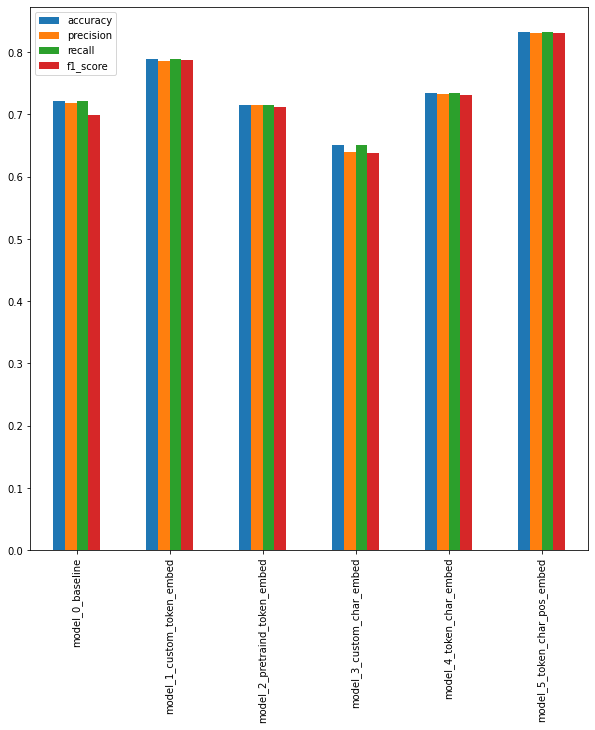

In [ ]:
all_model_results.plot(kind="bar", figsize=(10,10))

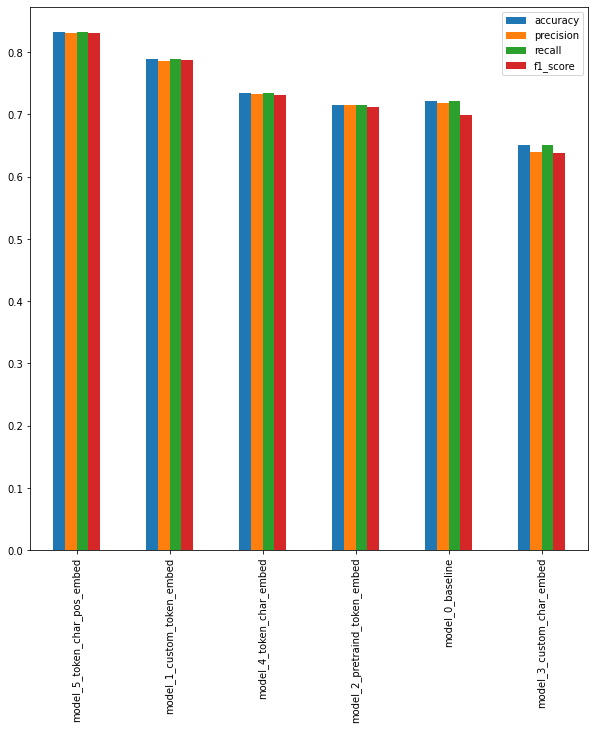

In [ ]:
all_model_results = all_model_results.sort_values("f1_score", ascending=False)
all_model_results.plot(kind="bar", figsize=(10,10))

In [ ]:
# save the best model: Model_5

model_5.save("/content/drive/MyDrive/tensorflow course/skimlit_best_model")

In [ ]:
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/tensorflow course/skimlit_best_model")

In [ ]:
# check if the model got saved corectly
loaded_model_preds = tf.argmax(loaded_model.predict(val_tribrid_dataset), axis=1)
loaded_model_preds[:5]

945/945 [==============================] - 33s 32ms/step


<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 3, 2, 2])>

In [ ]:
loaded_model_results = evaluation_dictonary(val_labels, loaded_model_preds)
loaded_model_results

{'accuracy': 0.8317555938037866,
 'precision': 0.8308030958285513,
 'recall': 0.8317555938037866,
 'f1_score': 0.8308213678461481}

In [ ]:
model_5_results == loaded_model_results

True